## Welcome to Week 4, Day 4

This is the start of an AWESOME project! Really simple and very effective.

### First - a heads up for Windows PC users

While executing this notebook, you might hit a problem with the Playwright browser raising a NotImplementedError.

This should work when we move to python modules, but it can cause problems in Windows in a notebook.

If you it this error and would like to run the notebook, you need to make a small change which seems quite hacky!

1. Right click in `.venv` in the File Explorer on the left and select "Find in folder"
2. Search for `asyncio.set_event_loop_policy(WindowsSelectorEventLoopPolicy())`  
3. That code should be found in a line of code in a file called `kernelapp.py`
4. Comment out that line of code in that file! And save the file. (And in fact, student William Lapa tells me that he needed to comment out the entire else statement that this line is part of.)
5. Restart the kernel by pressing the "Restart" button above

Thank you to student Nicolas for finding this, and to Yaki, Zibin and Bhaskar for confirming that this worked for them!

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain.agents import Tool

from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver

In [2]:
#load_dotenv(override=True)
load_dotenv("/Users/alex/Desktop/00_projects/AI_agents/my_agents/.env", override=True)

True

### Asynchronous LangGraph

Okay, so I also am going to introduce this time asynchronous LandGraph, using LandGraph in async mode, which I promised was going to happen this week. And it's very similar to using LandGraph in sync mode. When we used to call tool.run to run a tool, you can now call await tool.arun to run the tool asynchronously by passing the same inputs, otherwise it's just the same. And to invoke the graph, if we would have said graph.invokeState before, we can now say await graph.ainvokeState. So that is just simply a way to run LandGraph in asynchronous mode, and that is what we're going to be doing. 

To run a tool:  
Sync: `tool.run(inputs)`  
Async: `await tool.arun(inputs)`

To invoke the graph:  
Sync: `graph.invoke(state)`  
Async: `await graph.ainvoke(state)`

For the state, I'm going to again be using a typed dict. So that means that it looks very much like when we use PydanticObjects. You just have one field I'm going to have called messages, it is annotated, the type is a list, and this is telling LandGraph we want it to use addMessages, which is a canned function that you can import. We want that to be the reducer, which is going to keep on adding messages whenever we return that ZOS state from a node. And we will start a graph builder with that state. 

In [4]:
class State(TypedDict):
    
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

Okay, so far so good. Okay, next up, we are going to create a tool that we did last time, so we can do it nice and quickly here. It is the push notification tool. We define our function push, and then we wrap it, package it in a tool called tool push, which describes what it is, it calls the function, and that is all we need to do. 

In [5]:
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = "https://api.pushover.net/1/messages.json"

def push(text: str):
    """Send a push notification to the user"""
    requests.post(pushover_url, data = {"token": pushover_token, "user": pushover_user, "message": text})

tool_push = Tool(
        name="send_push_notification",
        func=push,
        description="useful for when you want to send a push notification"
    )

### Next: Install Playwright

 PlayWrite. Do you know what PlayWrite is? PlayWrite is one of these browser automation bits of software. It's considered the next generation of Selenium, which many, many people have used. I've used Selenium an awful lot. PlayWrite is by Microsoft, and it's a very nice framework for running a browser. It's traditionally, originally used for testing, so it's used for test purposes. A lot of people also use it for web scraping, because if you just try and request a web page, you just get back the server content. If you use something like Selenium or PlayWrite, you can actually render it in a browser, run the JavaScript, paint the page, and then use that to actually get the content. So PlayWrite is a powerful tool for running a browser window, and it can do so what they call headless, which means you don't even see the browser window. It's just like running behind the scenes. Or not headless, headful, in which case you see the browser screen yourself and you can interact with it. So that is PlayWrite. You may already know it. A lot of people use PlayWrite. This is how you install it. You type PlayWrite install to do it on Windows and Mac OS or Linux. It's this longer command, and it will then be installed. And if you have problems with that, then let me know, but hopefully not. 

On Windows and MacOS:  
`playwright install`

On Linux:  
`playwright install —with-reps chromium`

### Introducing nest_asyncio

Python async code only allows for one "event loop" processing aynchronous events.

The `nest_asyncio` library patches this, and is used for special situations, if you need to run a nested event loop.

---

Okay, one other thing to mention, one other little detail here, and this is just for running it in a notebook. One of the problems, one of the challenges with AsyncIO is that AsyncIO runs an event loop. And when it runs an event loop, it runs this thing that's just constantly making sure that it's running anything that's being awaited. And then when it's holding on IO, it runs something else that's being awaited. And one of the problems is that AsyncIO only supports one event loop, and if there's an event loop running, you can't, within that event loop, run another event loop. And we're running an event loop as part of running this notebook right now. And so that can cause problems when you try and kick off Async processors within Async processors. And so there is this package called NestAsyncIO that's quite popular, which you can just simply use this, and then it patches AsyncIO so that you can have an event loop within an event loop. And as you will soon understand from me prattling away, we're going to want that because we're going to want to run PlayWrite asynchronously. Because we're going to build an agent that can drive PlayWrite. And so we're going to need that concept of an event loop within an event loop. But when we later put this into Python code, we actually won't need this anymore, but we'll need it for now. 

In [6]:
import nest_asyncio
nest_asyncio.apply()

### The LangChain community

One of the remarkable things about LangChain is the rich community around it.

So one of the incredible things about LandGraph and LandChain, I'm becoming a convert of both, is that they come with so many great tools out of the box. Many of them are in the community package. There's actually a couple of different ways that you can run PlayWrite. There's two sets of tools. One of them is a more simplistic one that's just a bit higher level. This one that I've got here, the PlayWrite Browser Toolkit, this is a lower level set of tools which provides a bunch of different tools. We're going to create this. So this is creating an asynchronous PlayWrite browser. And then it's building a toolkit from that browser. And now we've got the tools into a variable tool. 

Check this out:


In [7]:
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser

async_browser =  create_async_playwright_browser(headless=False)  # headful mode
toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
tools = toolkit.get_tools()

So I'm just going to print these. And here are all of the tools that we get in this package. We get something that lets you click on an element in a web page, navigate the browser to a particular web page, go to the previous web page. Press the back button, extract text from a web page, extract hyperlinks, get elements, and then the current web page. So it gives you quite granular control over what's going on in this PlayWrite browser. So again, to recap, PlayWrite allows you to launch a browser window. And then this LandGraph or LandChain set of tools gives us a series of tools that will allow us to interact with that browser, open windows, navigate, read the text, read the elements, do that kind of thing. That's pretty cool. And that is something we're going to be able to arm our agent to be able to use.

In [8]:
for tool in tools:
    print(f"{tool.name}={tool}")

click_element=async_browser=<Browser type=<BrowserType name=chromium executable_path=/Users/alex/Library/Caches/ms-playwright/chromium-1169/chrome-mac/Chromium.app/Contents/MacOS/Chromium> version=136.0.7103.25>
navigate_browser=async_browser=<Browser type=<BrowserType name=chromium executable_path=/Users/alex/Library/Caches/ms-playwright/chromium-1169/chrome-mac/Chromium.app/Contents/MacOS/Chromium> version=136.0.7103.25>
previous_webpage=async_browser=<Browser type=<BrowserType name=chromium executable_path=/Users/alex/Library/Caches/ms-playwright/chromium-1169/chrome-mac/Chromium.app/Contents/MacOS/Chromium> version=136.0.7103.25>
extract_text=async_browser=<Browser type=<BrowserType name=chromium executable_path=/Users/alex/Library/Caches/ms-playwright/chromium-1169/chrome-mac/Chromium.app/Contents/MacOS/Chromium> version=136.0.7103.25>
extract_hyperlinks=async_browser=<Browser type=<BrowserType name=chromium executable_path=/Users/alex/Library/Caches/ms-playwright/chromium-1169/ch

And here are all of the tools that we get in this package. We get something that lets you click on an element in a web page, navigate the browser to a particular web page, go to the previous web page, I press the back button, extract text from a web page, extract hyperlinks, get elements, and then the current web page. So it gives you quite granular control over what's going on in this Playwright browser. So again, to recap, Playwright allows you to launch a browser window, and then this lang graph or lang chain set of tools gives us a series of tools that will allow us to interact with that browser, open windows, navigate, read the text, read the elements, do that kind of thing. That's pretty cool. And that is something we're going to be able to arm our agent to be able to use.

In [9]:
tool_dict = {tool.name:tool for tool in tools}

navigate_tool = tool_dict.get("navigate_browser")
extract_text_tool = tool_dict.get("extract_text")

    
await navigate_tool.arun({"url": "https://www.cnn.com"})
text = await extract_text_tool.arun({})

In [10]:
import textwrap
print(textwrap.fill(text))

Breaking News, Latest News and Videos | CNN CNN values your feedback
1. How relevant is this ad to you? 2. Did you encounter any technical
issues? Video player was slow to load content Video content never
loaded Ad froze or did not finish loading Video content did not start
after ad Audio on ad was too loud Other issues Ad never loaded Ad
prevented/slowed the page from loading Content moved around while ad
loaded Ad was repetitive to ads I've seen previously Other issues
Cancel Submit Thank You! Your effort and contribution in providing
this feedback is much
appreciated. Close Ad Feedback Close icon US World Politics Business
Health Entertainment Style Travel Sports Science Climate Weather
Ukraine-Russia War Israel-Hamas War Games More US World Politics
Business Health Entertainment Style Travel Sports Science Climate
Weather Ukraine-Russia War Israel-Hamas War Games Watch Listen Live TV
Subscribe Sign in My Account Settings Newsletters Topics you follow
Sign out Your CNN account Sign 

In [11]:
all_tools = tools + [tool_push]

In [12]:

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(all_tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


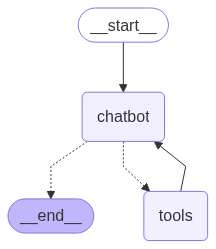

In [13]:

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=all_tools))
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### Ejecuta la interfaz web Gradio + Playwright

Para lanzar la app web fuera de Jupyter y evitar problemas de hilos o subprocessos,
ejecuta la siguiente celda.  
Después, abre [http://localhost:7860](http://localhost:7860) en tu navegador.


In [32]:
# config = {"configurable": {"thread_id": "10"}}

# async def chat(user_input: str, history):
#     result = await graph.ainvoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
#     return result["messages"][-1].content


# gr.ChatInterface(chat, type="messages").launch()